In [68]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import linregress
import os

os.chdir("C:/Users/caden/vieregg-lab/xm125/benchmarking")
df_raw_test1 = pd.read_csv("data/test1.csv")
df_raw_reg_0 = df_raw_test1[df_raw_test1["register"]==0]
df_raw_test1

,trial,register,rdistance,strength,edistance
0,0,0.0,104.0,-2940.0,100
1,0,1.0,183.0,-5122.0,100
2,0,0.0,90.0,-2949.0,100
3,0,1.0,182.0,-4806.0,100
4,0,2.0,275.0,-4343.0,100
...,...,...,...,...,...
495,9,2.0,223.0,-3642.0,82
496,9,0.0,79.0,5452.0,82
497,9,1.0,140.0,-3947.0,82
498,9,2.0,222.0,-3767.0,82


In [58]:
def get_stats(df):

    df["error_mm"] = df["rdistance"] - df["edistance"]
    df["abs_strength"] = df["strength"].abs()

    stats = (
        df[df["register"] == 0]
        .groupby("trial")
        .agg(
        median_distance=("rdistance", "median"),
        mean_distance=("rdistance", "mean"),
        std_distance=("rdistance", "std"),
        mean_strength=("abs_strength", "mean"),
        median_strength=("abs_strength", "median"),
        count=("rdistance", "size"),
        median_error=("error_mm", "median"),
        expected_distance=("edistance", "median")
    )
    .reset_index()
    )


    return stats


def remove_outliers_per_trial(
    df,
    value_col="rdistance",
    trial_col="trial",
    n_std=1.0,
):
    """
    Removes rows where value_col is more than n_std standard deviations
    from the median, computed per trial.
    """
    def _filter(group):
        med = group[value_col].median()
        std = group[value_col].std()
        return group[abs(group[value_col] - med) <= n_std * std]

    return (
        df.groupby(trial_col, group_keys=False)
          .apply(_filter)
          .reset_index(drop=True)
    )

def plot_cleaned_regression(raw_df, x_col="expected_distance", y_col="median_distance", n_std=1.0, figsize=(6,4)):
    """
    Plots a scatter and line-of-best-fit for a single register's data,
    automatically removing outliers beyond `n_std` standard deviations.

    Parameters:
        raw_df (pd.DataFrame): Raw data for one register
        x_col (str): Column name for x-axis (default "expected_distance")
        y_col (str): Column name for y-axis (default "median_distance")
        n_std (float): Number of standard deviations from median to consider as inliers
        figsize (tuple): Figure size
    """
    # Remove outliers

    raw_df[y_col] = raw_df[y_col].abs()

    med = raw_df[y_col].median()
    std = raw_df[y_col].std()
    clean_df = raw_df[abs(raw_df[y_col] - med) <= n_std * std]

    # Plot scatter of cleaned data
    plt.figure(figsize=figsize)
    plt.scatter(clean_df[x_col], clean_df[y_col], label="Data", color="blue")

    # Add regression line
    sns.regplot(
        x=x_col,
        y=y_col,
        data=clean_df,
        scatter=False,  # scatter already plotted
        ci=None,        # no confidence interval
        label="Best Fit",
        color="red"
    )

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"{y_col} vs {x_col} (Outliers removed)")
    plt.legend()
    plt.show()

def get_slope_from_cleaned(raw_df, x_col="expected_distance", y_col="median_distance", n_std=1.0):
    # Remove outliers
    med = raw_df[y_col].median()
    std = raw_df[y_col].std()
    clean_df = raw_df[abs(raw_df[y_col] - med) <= n_std * std]

    # Compute slope using linear regression
    slope, intercept, r_value, p_value, std_err = linregress(clean_df[x_col], clean_df[y_col])

    return slope, intercept, r_value  # r_value is correlation coefficient


C:\Users\caden\AppData\Local\Temp\ipykernel_19192\1449740038.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df[y_col] = raw_df[y_col].abs()


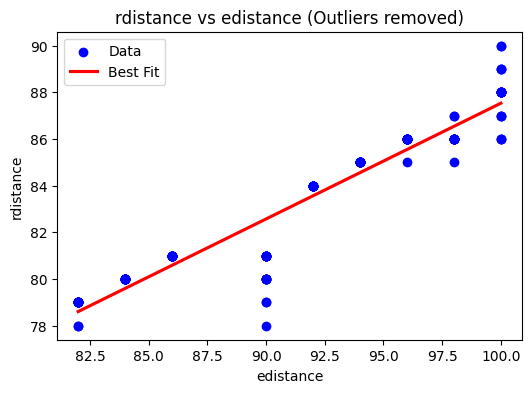

C:\Users\caden\AppData\Local\Temp\ipykernel_19192\1449740038.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df[y_col] = raw_df[y_col].abs()


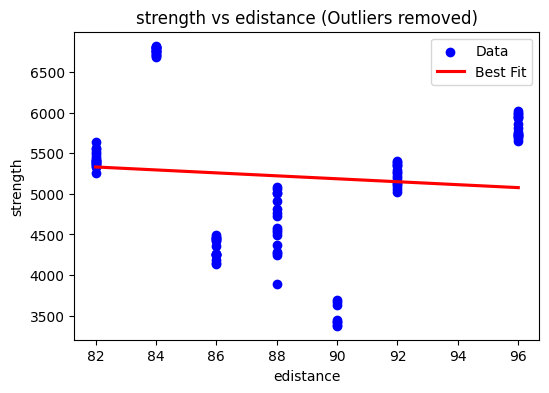

Slope: 0.496, Intercept: 37.922, R: 0.946


In [59]:
plot_cleaned_regression(df_raw_test1[df_raw_test1["register"] == 0], x_col="edistance", y_col="rdistance")
plot_cleaned_regression(df_raw_test1[df_raw_test1["register"] == 0], x_col="edistance", y_col="strength")
slope, intercept, r_value = get_slope_from_cleaned(df_raw_test1[df_raw_test1["register"] == 0], x_col="edistance", y_col="rdistance")
print(f"Slope: {slope:.3f}, Intercept: {intercept:.3f}, R: {r_value:.3f}")

C:\Users\caden\AppData\Local\Temp\ipykernel_19192\1187574846.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_reg_0["strength_abs"] = df_raw_reg_0["strength"].abs()


<Axes: xlabel='edistance', ylabel='strength_abs'>

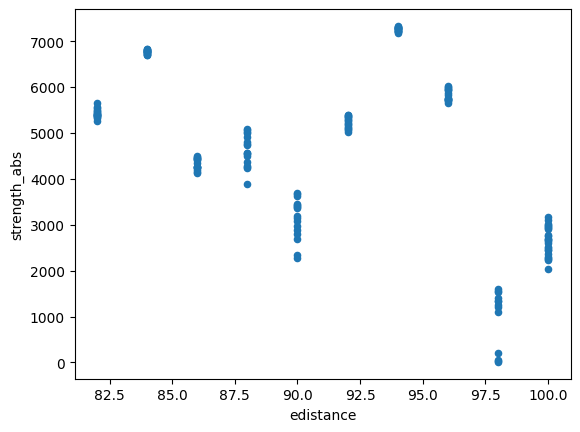

In [71]:
df_raw_reg_0["strength_abs"] = df_raw_reg_0["strength"].abs()
df_raw_reg_0.plot.scatter(x="edistance", y="strength_abs")